In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **IMPORT, INSTALL LIB**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 22.6 MB/s 
     |████████████████████████████████| 182 kB 73.3 MB/s 
     |████████████████████████████████| 7.6 MB 58.1 MB/s 


In [ ]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.0 MB 4.6 MB/s 
     |████████████████████████████████| 591 kB 60.8 MB/s 
     |████████████████████████████████| 1.0 MB 62.8 MB/s 
     |████████████████████████████████| 235 kB 75.8 MB/s 


In [ ]:
!pip install fastBPE
!pip install fairseq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp38-cp38-linux_x86_64.whl size=492594 sha256=eebcd6045ef8519d5ccb87114bd7aaf52187ff16e03f7017b6929499044d494e
  Stored in directory: /root/.cache/pip/wheels/64/a8/c6/07fb6443539116f05252337e751bbccd2bd2dd6c585ba94ca8
Successfully built fastBPE
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.0 MB 34.3 MB/s 
     |████████████████████████████████| 241 kB 70.0 MB/s 
     |████████████████████████████████| 118 kB 35.5 MB/s 
     |████████████████████████████████| 123 kB 55.6 MB/s 
     |████████████████████████████████| 112 kB 50.0 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141231 sha256=ccbb31c5ed3a4dfde08e96a65b7090df60d8e6afba85af88341ef98ab1200ee7
  Stored in directory: /root/.cac

In [ ]:
!pip install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 22.0 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645950 sha256=54b3c5a7154723d51ec0c4a6f256f370cd729fe2a432b45df2acecd3e7274800
  Stored in directory: /root/.cache/pip/wheels/3c/e9/86/706911c12e307aeb9a2702399f0dad38d36f1d6f9dde8af35e
Successfully built vncorenlp
--2022-12-06 12:24:02--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.07s   

2022-1

In [ ]:
# !wget https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
# !tar -xzvf PhoBERT_base_fairseq.tar.gz
# !wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
# !tar -xzvf PhoBERT_base_transformers.tar.gz

In [ ]:
import transformers 
from transformers import BertForSequenceClassification
from transformers import  RobertaConfig, AdamW
from underthesea import text_normalize

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import re

import fastBPE
from vncorenlp import VnCoreNLP
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, accuracy_score

import random
from tqdm import tqdm_notebook

device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
rdrsegmenter = VnCoreNLP("./drive/MyDrive/ML/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [ ]:
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="./drive/MyDrive/ML/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("./drive/MyDrive/ML/PhoBERT_base_transformers/dict.txt")

# **LOADING DATA**

In [ ]:
df = pd.read_json('./drive/MyDrive/ML/trainformat.json')
df.head(10)

,RevId,UserId,Comment,image_urls,Rating
0,3839333,10106093,"Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...",[https://images.foody.vn/res/g97/966781/s800/f...,8.6
1,2824877,786914,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,[https://images.foody.vn/res/g69/688413/s800/f...,5.8
2,9816702,22467889,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",[https://images.foody.vn/res/g72/715078/s800/f...,9.6
3,2684585,1889449,Em có đọc review thấy mng bảo trà sữa nướng đề...,[https://images.foody.vn/res/g90/895545/s800/f...,4.6
4,2737987,8839942,"Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...",[https://images.foody.vn/res/g4/30186/s800/foo...,6.2
5,2696323,15468841,"Đồ ăn ngon, đặt qua now shop để k cẩn thận bị ...",[https://images.foody.vn/res/g24/236758/s800/f...,5.0
6,401474,939065,Nhà hàng yêu thích của mình đây nè! Đến đây mì...,[https://images.foody.vn/res/g1/273/s800/foody...,8.2
7,1943251,1585910,"🔸Vị trí: mặt đường Trung Yên rất dễ tìm, một d...",[https://images.foody.vn/res/g71/702137/s800/f...,8.0
8,10864419,10729650,"Mình đã ăn tại đây và rất ngon,\nChuẩn vị phố ...",[https://images.foody.vn/res/g105/1046322/s800...,9.6
9,2533846,2022193,"Thịt mềm, sốt ngon, dưa góp ăn cùng đỡ ngán\nM...",[https://images.foody.vn/res/g86/854376/s800/f...,7.6


In [ ]:
df.isnull().sum()

RevId         0
UserId        0
Comment       0
image_urls    0
Rating        0
dtype: int64

In [ ]:
del df['image_urls']
del df['UserId']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9071 entries, 0 to 9070
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RevId    9071 non-null   int64  
 1   Comment  9071 non-null   object 
 2   Rating   9071 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 212.7+ KB


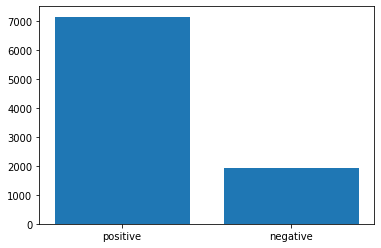

In [ ]:
import matplotlib.pyplot as plt

pos_num = 0
neg_num = 0
for d in df['Rating']:
  if d >= 6.0: pos_num += 1
  else: neg_num += 1

_x = [pos_num, neg_num]
_y = ['positive', 'negative']
plt.bar(_y, _x)
plt.show()

874


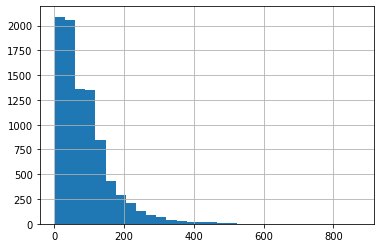

In [ ]:
seq_len = [len(i.split()) for i in df['Comment']]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

# **PREPROCESSING**

Chuẩn hóa lại dấu câu

In [ ]:
def normalize_vie(text):
  text = text_normalize(text)
  return text
text = 'Haì lắm!!!'
print(normalize_vie(text))

Hài lắm ! ! !


Chuyển về viết thường

In [ ]:
def lower_text(text):
  text = text.lower()
  return text
text = 'Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trông rất thích'
print(lower_text(text))

xôi dẻo, đồ ăn đậm vị. hộp xôi được lót lá trông rất thích


Xóa các biểu tượng cảm xúc

In [ ]:
def remove_emoji(text):
  emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                            "]+", flags=re.UNICODE)
  
  text = emoji_pattern.sub(r'', text)
  return text
text = '👉👉👉LẨU THÁI TÔMYUM\n👉👉Đc: 19 Lò Đúc-HBT-HN\n👉T...'
print(remove_emoji(text))

LẨU THÁI TÔMYUM
Đc: 19 Lò Đúc-HBT-HN
T...


Xóa các kí tự đặc biệt

In [ ]:
import string
def remove_symbol(text):
  text = [sentence.translate(str.maketrans('', '', string.punctuation)) for sentence in text]
  res = ''
  for i in text:
    res += i
  return res
text=  '👉👉👉LẨU THÁI TÔMYUM\n👉👉Đc: 19 Lò Đúc-HBT-HN\n👉T'
print(remove_symbol(text))

👉👉👉LẨU THÁI TÔMYUM
👉👉Đc 19 Lò ĐúcHBTHN
👉T


Chuẩn hóa láy âm

In [ ]:
import re
def remove_duplicate_char(text):
  return re.sub(r'(\D)\1+', r'\1', text)
text = 'tuyệttt vời quáaaa điii '
print(remove_duplicate_char(text))

tuyệt vời quáa đi 


Xóa stopword

In [ ]:
# file_txt = open('/content/drive/MyDrive/ML/stop_word.txt')
# stopwords = []
# for x in file_txt:
#   text = x[:-1]
#   stopwords.append(text)

# def remove_stopword(text):
#   text = " ".join([word for word in text.split() if word not in stopwords])
#   return text
# text = 'a ha la haaha'
# print(remove_stopword(text))
import pandas as pd

col_name = ["word"]
sp = pd.read_csv("/content/drive/MyDrive/ML/stop_word.txt", names=col_name)
stop_words = sp["word"]
def remove_stop_words(text):
    out = ""
    for stop_word in stop_words:
        if stop_word in text:
            list_text = text.split(stop_word)
            for i in list_text:
                out += i
            return out
text = "ai đó "
out_text = remove_stop_words(text)
print(out_text)

 đó 


PROCESSING

In [ ]:
def preprocessing(df):
  i = 0
  for text in df['Comment']:
    text = normalize_vie(text)
    text = lower_text(text)
    text = remove_emoji(text)
    text = remove_symbol(text) 
    text = remove_duplicate_char(text)
    #text = remove_stop_words(text)
    df['Comment'].loc[i] = text
    i += 1
  return df
df = preprocessing(df)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df.head(10)

,RevId,Comment,Rating
0,3839333,xôi dẻo đồ ăn đậm vị hộp xôi được lót lá trông...,8.6
1,2824877,gọi ship 1 xuất cari gà bánh nan và 3 miếng gà...,5.8
2,9816702,thời tiết lạnh như này cả nhà rủ nhau đến lega...,9.6
3,2684585,em có đọc review thấy mng bảo trà sữa nướng đề...,4.6
4,2737987,đồ ăn rất ngon nhà hàng cũng rất đẹp tất cả đề...,6.2
5,2696323,đồ ăn ngon đặt qua now shop để k cẩn thận bị đ...,5.0
6,401474,nhà hàng yêu thích của mình đây nè đến đây mìn...,8.2
7,1943251,vị trí mặt đường trung yên rất dễ tìm một dãy...,8.0
8,10864419,mình đã ăn tại đây và rất ngon chuẩn vị phố cổ...,9.6
9,2533846,thịt mềm sốt ngon dưa góp ăn cùng đỡ ngán mỗi ...,7.6


In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state=23)

In [ ]:
# Train_text, Train_test, train_re_id
def make_train_valid_text(df_train, df_test):
  train_text, train_label = [], []
  test_text, test_label = [], []
  for sample in df_train['Comment']:
    splits = str(sample).strip().split('\n')
    text = ' '.join(splits[:])[:]
    text = rdrsegmenter.tokenize(text)
    text = ' '.join([' '.join(x) for x in text])
    train_text.append(text)

  if len(df_test) != 0:
    for sample in df_train['Rating']:
      label = sample
      if label >= 6.0: train_label.append(1); # if rating >= 6 => positive: 1 else negative: 0
      else: train_label.append(0)
  else: 
    for i in df_train['RevId']:
      train_label.append(i)
  # Test_text, Test_label
  if len(df_test) != 0:
    for sample in df_test['Comment']:
      splits = sample.strip().split('\n')
      text = ' '.join(splits[:])[:]
      text = rdrsegmenter.tokenize(text)
      text = ' '.join([' '.join(x) for x in text])
      test_text.append(text)
    if len(df_test) != 0:
      for sample in df_test['Rating']:
        label = sample
        if label >= 6.0: test_label.append(1) # if rating >= 6 => positive: 1 else negative: 0
        else: test_label.append(0)
  
  return train_text, train_label, test_text, test_label

In [ ]:
MAX_LEN = 256 # Max legth of sentence, Sentences shorter than 256 subwords are padded with 0 at the end, longer sentences are trimmed to 256.
def make_train_test_ids(train_text, test_text):
  # Making train ids
  train_ids = []
  for text in train_text:
    sub_words = '<s>' + bpe.encode(text) + '</s>'
    encode_text = vocab.encode_line(sub_words, append_eos=True, add_if_not_exist=False).long().tolist()
    train_ids.append(encode_text)
  train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  
  # Making test ids 
  test_ids = []
  if len(test_text) != 0:
    for text in test_text:
      sub_words = '<s> ' + bpe.encode(text) + ' </s>'
      encode_text = vocab.encode_line(sub_words, append_eos=True, add_if_not_exist=False).long().tolist()
      test_ids.append(encode_text)
    test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  
 

  return train_ids, test_ids

In [ ]:
# Make mask include 2 values 0, 1 to input value for Transformer
# Mask: This mask indicates which values ​​of the string have been padded.
def make_mask(train_ids, test_ids):
  # Making train mask
  train_mask = []
  for index in train_ids:
      mask = [int(token_id > 0) for token_id in index]
      train_mask.append(mask)

  # Making test mask
  test_mask = []
  if len(test_ids) != 0:
    for index in test_ids:
      mask = [int(token_id > 0) for token_id in index]
      test_mask.append(mask)
  
  return train_mask, test_mask

In [ ]:
def make_dataloader(train_ids, train_label, train_mask, test_ids, test_label, test_mask):
  # convert to tensor and use torch's DataLoader to create the dataloader
  train_inputs = torch.tensor(train_ids)
  train_labels = torch.tensor(train_label)
  train_masks = torch.tensor(train_mask)
  if len(test_ids) != 0 and len(test_label) != 0 and len(test_mask) != 0:
    test_inputs = torch.tensor(test_ids)
    test_labels = torch.tensor(test_label)
    test_masks = torch.tensor(test_mask)

  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = SequentialSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

  test_dataloader = None
  if len(test_ids) != 0 and len(test_label) != 0 and len(test_mask) != 0:
    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

  return train_dataloader, test_dataloader

In [ ]:
train_text, train_label, test_text, test_label = make_train_valid_text(df_train, df_test)
train_ids, test_ids = make_train_test_ids(train_text, test_text)
train_mask, test_mask = make_mask(train_ids, test_ids)
train_dataloader, test_dataloader = make_dataloader(train_ids, train_label, train_mask, test_ids, test_label, test_mask)

# **MODEL TRAINING, VALIDATING**

In [ ]:
from transformers import AutoModel
# config = RobertaConfig.from_pretrained(
#     "/content/drive/MyDrive/ML/PhoBERT_base_transformers/config.json", from_tf=False, num_labels = 256, output_hidden_states=False,
# )
BERT_SA = AutoModel.from_pretrained("vinai/phobert-base")

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for name, param in BERT_SA.named_parameters():
    if name.startswith("embeddings"): 
        param.requires_grad = False
    if name.startswith("encoder.layer.0"): 
        param.requires_grad = False
    if name.startswith("encoder.layer.1"): 
        param.requires_grad = False
    if name.startswith("encoder.layer.2"): 
        param.requires_grad = False
    if name.startswith("encoder.layer.3"): 
        param.requires_grad = False
    if name.startswith("encoder.layer.4"): 
        param.requires_grad = False
    if name.startswith("encoder.layer.5"): 
        param.requires_grad = False
    if name.startswith("encoder.layer.6"): 
        param.requires_grad = False
    if name.startswith("encoder.layer.7"): 
        param.requires_grad = False
    if name.startswith("encoder.layer.10"): 
        param.requires_grad = True
    if name.startswith("encoder.layer.11"): 
        param.requires_grad = True

In [ ]:
for name, param in BERT_SA.named_parameters():
     print(name, param.requires_grad)

embeddings.word_embeddings.weight False
embeddings.position_embeddings.weight False
embeddings.token_type_embeddings.weight False
embeddings.LayerNorm.weight False
embeddings.LayerNorm.bias False
encoder.layer.0.attention.self.query.weight False
encoder.layer.0.attention.self.query.bias False
encoder.layer.0.attention.self.key.weight False
encoder.layer.0.attention.self.key.bias False
encoder.layer.0.attention.self.value.weight False
encoder.layer.0.attention.self.value.bias False
encoder.layer.0.attention.output.dense.weight False
encoder.layer.0.attention.output.dense.bias False
encoder.layer.0.attention.output.LayerNorm.weight False
encoder.layer.0.attention.output.LayerNorm.bias False
encoder.layer.0.intermediate.dense.weight False
encoder.layer.0.intermediate.dense.bias False
encoder.layer.0.output.dense.weight False
encoder.layer.0.output.dense.bias False
encoder.layer.0.output.LayerNorm.weight False
encoder.layer.0.output.LayerNorm.bias False
encoder.layer.1.attention.self.query

In [ ]:
from torch.nn import CrossEntropyLoss 
class phoBERT(nn.Module):
    def __init__(self):
        super(phoBERT, self).__init__()
        self.bert = BERT_SA
        self.dropout = nn.Dropout(0.1)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.num_labels = 2

    def forward(self, input_ids, input_mask, input_label=None):
        outputs = self.bert(input_ids, 
                            token_type_ids = None, 
                            attention_mask = input_mask)
        pooled_output = outputs[1]

        pooled_output = self.fc1(pooled_output)
        pooled_output = self.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.fc2(pooled_output)
        logits = torch.sigmoid(logits)
        return logits

In [ ]:
!CUDA_LAUNCH_BLOCKING=1

In [ ]:
model = phoBERT()
model.to(device)

phoBERT(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='macro')
    
    return accuracy_score(pred_flat, labels_flat), F1_score

In [ ]:
acc = []
_loss = []
def running():
  epochs = 4
  param_optimizer = list(model.named_parameters())
  loss_fct = CrossEntropyLoss()
  no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
  ]

  optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)
  best_accuracy = 0
  for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    model.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0
    
    for step, batch in tqdm_notebook(enumerate(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        logits = model(b_input_ids, b_input_mask, b_labels)
        loss = loss_fct(logits.view(-1, 2), b_labels.view(-1))
        total_loss += loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        nb_train_steps += 1
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    print(" Average training loss: {0:.4f}".format(avg_train_loss))

    print("Running Test...")
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    for batch in tqdm_notebook(test_dataloader):

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask)
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)
            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    if best_accuracy < eval_accuracy/nb_eval_steps:
      best_accuracy = eval_accuracy/nb_eval_steps
      torch.save(model.state_dict(), '/content/drive/MyDrive/ML/model_best.pt')
    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    acc.append(eval_accuracy/nb_eval_steps)
    _loss.append(avg_train_loss)
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
  print("Training complete!")

In [ ]:
#@title
if __name__ == '__main__':
  running()

======== Epoch 1 / 4 ========
Training...


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-37-07a49ec18763>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in tqdm_notebook(enumerate(train_dataloader)):


0it [00:00, ?it/s]

 Accuracy: 0.8551
 F1 score: 0.6854
 Average training loss: 0.4661
Running Test...


<ipython-input-37-07a49ec18763>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(test_dataloader):


  0%|          | 0/29 [00:00<?, ?it/s]

 Accuracy: 0.8987
 F1 score: 0.8177
======== Epoch 2 / 4 ========
Training...


<ipython-input-37-07a49ec18763>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in tqdm_notebook(enumerate(train_dataloader)):


0it [00:00, ?it/s]

 Accuracy: 0.9103
 F1 score: 0.8525
 Average training loss: 0.4019
Running Test...


<ipython-input-37-07a49ec18763>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(test_dataloader):


  0%|          | 0/29 [00:00<?, ?it/s]

 Accuracy: 0.9052
 F1 score: 0.8279
======== Epoch 3 / 4 ========
Training...


<ipython-input-37-07a49ec18763>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in tqdm_notebook(enumerate(train_dataloader)):


0it [00:00, ?it/s]

 Accuracy: 0.9186
 F1 score: 0.8637
 Average training loss: 0.3933
Running Test...


<ipython-input-37-07a49ec18763>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(test_dataloader):


  0%|          | 0/29 [00:00<?, ?it/s]

 Accuracy: 0.9073
 F1 score: 0.8330
======== Epoch 4 / 4 ========
Training...


<ipython-input-37-07a49ec18763>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in tqdm_notebook(enumerate(train_dataloader)):


0it [00:00, ?it/s]

 Accuracy: 0.9176
 F1 score: 0.8622
 Average training loss: 0.3936
Running Test...


<ipython-input-37-07a49ec18763>:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(test_dataloader):


  0%|          | 0/29 [00:00<?, ?it/s]

 Accuracy: 0.9041
 F1 score: 0.8274
Training complete!


# **Prediction**

In [ ]:
submit_df = pd.read_csv('/content/drive/MyDrive/ML/test.csv')
print(submit_df)

      Unnamed: 0    RevId    UserId  \
0              0   781115   1326532   
1              1  1219481    422306   
2              2  1703765   9779143   
3              3  4870346  12924388   
4              4  2638711   1134279   
...          ...      ...       ...   
5098        5098  1025826    132889   
5099        5099  1278470   1691594   
5100        5100  2565212   9989615   
5101        5101  3766155  17686862   
5102        5102  1070891   1141468   

                                                Comment  \
0     Trà táo 35k\nCookie socola 38k \nNước ở đây bì...   
1     Hôm rồi trung tâm mình tổ chức noel party ở đâ...   
2     Thịt gà của quán là nhất đấy. Đi ăn gọi liền 4...   
3     Hai đứa ăn xong đau bụng cả ngày\nChân gà ok n...   
4     Mình vừa thử trưa nay. Điểm cộng đầu tiên là b...   
...                                                 ...   
5098  Bún riêu ở đây ngon mà, lúc nào cũng đông, thế...   
5099  Quán ngồi thoải mái và cưc thích ❤ menu đa dạn...   


In [ ]:
submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5103 non-null   int64 
 1   RevId       5103 non-null   int64 
 2   UserId      5103 non-null   int64 
 3   Comment     5100 non-null   object
 4   image_urls  5103 non-null   object
dtypes: int64(3), object(2)
memory usage: 199.5+ KB


In [ ]:
del submit_df['Unnamed: 0']
del submit_df['UserId']
del submit_df['image_urls']

In [ ]:
submit_df['Comment'].fillna("ngon")

0       Trà táo 35k\nCookie socola 38k \nNước ở đây bì...
1       Hôm rồi trung tâm mình tổ chức noel party ở đâ...
2       Thịt gà của quán là nhất đấy. Đi ăn gọi liền 4...
3       Hai đứa ăn xong đau bụng cả ngày\nChân gà ok n...
4       Mình vừa thử trưa nay. Điểm cộng đầu tiên là b...
                              ...                        
5098    Bún riêu ở đây ngon mà, lúc nào cũng đông, thế...
5099    Quán ngồi thoải mái và cưc thích ❤ menu đa dạn...
5100    Quá thất vọng, chất lượng sản phẩm ngày càng đ...
5101    Giao hàng nhanh,  miếng băm chả đều ngon ko bị...
5102    Nhìn ở bên ngoài trông quán khá bé nhưng vào t...
Name: Comment, Length: 5103, dtype: object

In [ ]:
submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   RevId    5103 non-null   int64 
 1   Comment  5100 non-null   object
dtypes: int64(1), object(1)
memory usage: 79.9+ KB


In [ ]:
sub_text, sub_id = [], []
_b, _c = [], []
df_test = []
sub_text, sub_id, _b, _c = make_train_valid_text(submit_df, df_test)
sub_ids, _ids = make_train_test_ids(sub_text, _b)
sub_mask, _mask = make_mask(sub_ids, _ids)
submit_dataloader, _dataloader = make_dataloader(sub_ids, sub_id, sub_mask, _ids, _c, _mask)

In [ ]:
print(submit_df['RevId'])

0        781115
1       1219481
2       1703765
3       4870346
4       2638711
         ...   
5098    1025826
5099    1278470
5100    2565212
5101    3766155
5102    1070891
Name: RevId, Length: 5103, dtype: int64


In [ ]:
def make_predic_sheet(preds, labels):
  _dict =  []
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for i in range(len(pred_flat)):
    _dict.append([pred_flat[i], labels_flat[i]])
  return _dict

In [ ]:
def pred(submit_dataloader):
  predict = []
  id = []
  model.load_state_dict(torch.load('/content/drive/MyDrive/ML/model_best.pt'))
  model.eval()
  print("Running Test...")
  for batch in tqdm_notebook(submit_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      outputs = model(b_input_ids, b_input_mask)
      logits = outputs
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      pred_flat = np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()
      predict.append(pred_flat)
      id.append(labels_flat)
  return predict, id

In [ ]:
preds, id = pred(submit_dataloader)

Running Test...


<ipython-input-47-1688981ac5eb>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(submit_dataloader):


  0%|          | 0/160 [00:00<?, ?it/s]

In [ ]:
res = []
for i in range(0, len(preds)):
  for j in range(0, len(preds[i])):
    res.append([id[i][j], preds[i][j]])

In [ ]:
import csv

header = ['RevId', 'Rating']
data = res

with open('/content/drive/MyDrive/ML/submit_5_12_1.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write multiple rows
    writer.writerows(data)


# **VISUALIZATION**

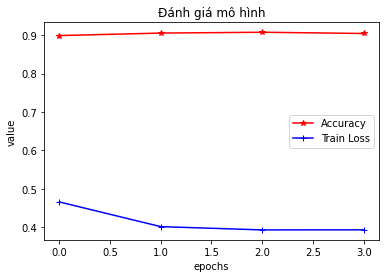

In [ ]:
import matplotlib.pyplot as plt

plt.plot(acc, 'r*-', label='Accuracy')
plt.plot(_loss, 'b+-', label='Train Loss')
plt.xlabel('epochs')
plt.ylabel('value')
plt.title('Đánh giá mô hình')
plt.legend(loc='best')
plt.show()